In [2]:


import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
from PIL import Image
import cv2
import math
import numpy as np
import glob
from collections import deque
from random import random, seed
from statistics import mean
import scipy
import time

In [4]:
training_data = np.load('data/training.npy', allow_pickle=True) # shape: (frame, calibration)
test_data = np.load('data/test.npy', allow_pickle=True) # shape: (frame,)

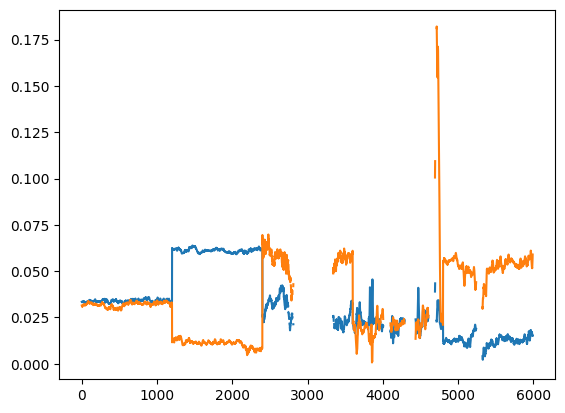

In [165]:
radians = training_data[:,1]
r1 = [r1 for r1, _ in radians]
r2 = [r2 for _, r2 in radians]
x = [i for i in range(len(radians))]

plt.plot(x, r1, label='pitch')
plt.plot(x, r2, label='yaw')

<AxesSubplot: >

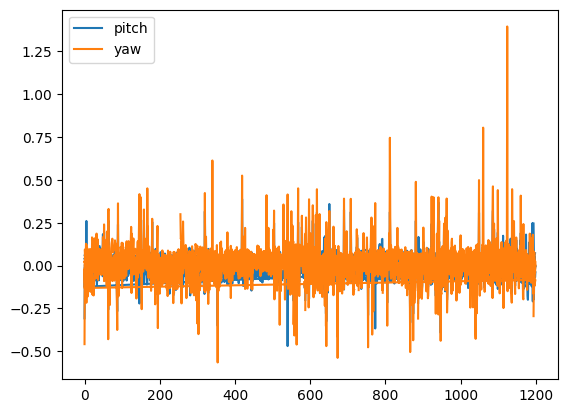

In [224]:
test_labels_0 = pd.read_csv('test/0.txt', names = ['pitch', 'yaw'], delim_whitespace=True)
test_labels_1 = pd.read_csv('test/1.txt', names = ['pitch', 'yaw'], delim_whitespace=True)
test_labels_2 = pd.read_csv('test/2.txt', names = ['pitch', 'yaw'], delim_whitespace=True)
test_labels_3 = pd.read_csv('test/3.txt', names = ['pitch', 'yaw'], delim_whitespace=True)
test_labels_4 = pd.read_csv('test/4.txt', names = ['pitch', 'yaw'], delim_whitespace=True)
test_videos = [test_labels_0, test_labels_1, test_labels_2, test_labels_3, test_labels_4]

test_labels = pd.concat(test_videos)

ax = plt.gca()
test_labels.plot(kind='line',y='pitch',ax=ax)
test_labels.plot(kind='line',y='yaw',ax=ax)
# why do I have negative values?
# why is it unclear where one video starts and the other ends?

In [237]:
train_labels_0 = pd.read_csv('labeled/0.txt', names = ['pitch', 'yaw'], delim_whitespace=True)
train_labels_1 = pd.read_csv('labeled/1.txt', names = ['pitch', 'yaw'], delim_whitespace=True)
train_labels_2 = pd.read_csv('labeled/2.txt', names = ['pitch', 'yaw'], delim_whitespace=True)
train_labels_3 = pd.read_csv('labeled/3.txt', names = ['pitch', 'yaw'], delim_whitespace=True)
train_labels_4 = pd.read_csv('labeled/4.txt', names = ['pitch', 'yaw'], delim_whitespace=True)
train_frames = [train_labels_0, train_labels_1, train_labels_2, train_labels_3, train_labels_4]

train_labels = pd.concat(train_frames)

<AxesSubplot: >

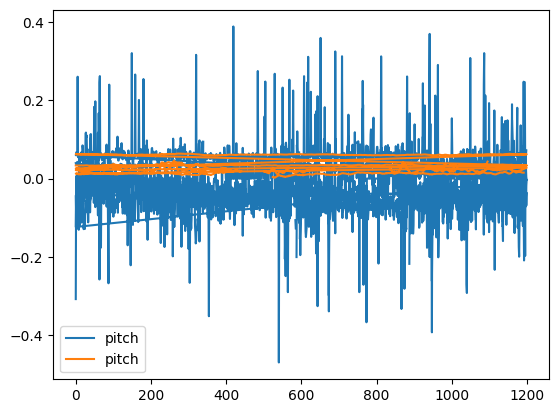

In [210]:
# pitch comparison
ax = plt.gca()
test_labels.plot(kind='line',y='pitch',ax=ax)
train_labels.plot(kind='line',y='pitch',ax=ax)

<AxesSubplot: >

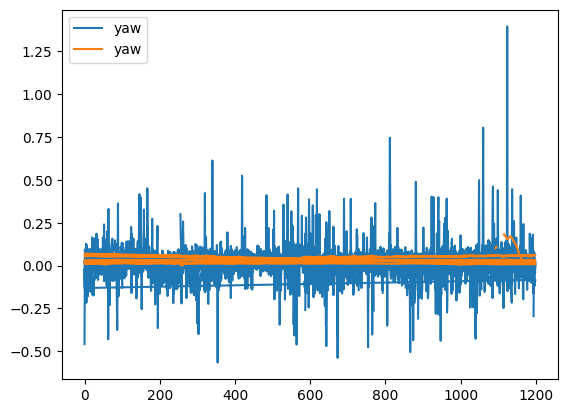

In [213]:
# yaw comparison
ax = plt.gca()
test_labels.plot(kind='line',y='yaw',ax=ax)
train_labels.plot(kind='line',y='yaw',ax=ax)

In [5]:
# CODE IN THIS BLOCK IS FROM https://github.com/commaai/openpilot/tree/master/common/transformations

# TESTING
focal_length = 910.0
frame_size = (1164, 874)

# aka 'K' aka camera_frame_from_view_frame
calib_challenge_intrinsics = np.array([
  [focal_length,  0.0,  float(frame_size[0])/2],
  [0.0,  focal_length,  float(frame_size[1])/2],
  [0.0,  0.0,                              1.0]])


def normalize(img_pts, intrinsics=calib_challenge_intrinsics):
  # normalizes image coordinates
  # accepts single pt or array of pts
  intrinsics_inv = np.linalg.inv(intrinsics)
  img_pts = np.array(img_pts)
  input_shape = img_pts.shape
  img_pts = np.atleast_2d(img_pts)
  img_pts = np.hstack((img_pts, np.ones((img_pts.shape[0], 1))))
  img_pts_normalized = img_pts.dot(intrinsics_inv.T)
  img_pts_normalized[(img_pts < 0).any(axis=1)] = np.nan
  return img_pts_normalized[:, :2].reshape(input_shape)


def get_calib_from_vp(vp):
  vp_norm = normalize(vp)
  yaw_calib = np.arctan(vp_norm[0])
  pitch_calib = -np.arctan(vp_norm[1]*np.cos(yaw_calib))
  roll_calib = 0
  return roll_calib, pitch_calib, yaw_calib

# Test to add for going from vp -> _roll, pitch, yaw: make the vp the center of the camera and see if 
# all angles are 0

# inserting a single point
test_vp = np.array([int(frame_size[0]/2), int(frame_size[1]/2)]) # center of the image, int not necessary when running
roll_calib, pitch_calib, yaw_calib = get_calib_from_vp(test_vp)
assert(roll_calib == 0.0 and pitch_calib == 0.0 and yaw_calib == 0.0), "Error with vp -> calibration step"

# inserting a list of points
# test_vp = np.array([frame_size[0]/2, frame_size[1]/2])
# test_vps = [test_vp, test_vp, test_vp, test_vp]
# roll_calib, pitch_calib, yaw_calib = get_calib_from_vp(test_vps)
# print(len(pitch_calib))
# assert(roll_calib == 0.0 and pitch_calib == 0.0 and yaw_calib == 0.0), "Error with vp -> calibration step"


In [6]:
# Tested assumption that when vp = center of img, the pitch = yaw = 0.0 would yield 100% MSE according to eval.py (it does)

# vid[0] is the name of the file, vid[1] is the video data
vid_5 = ('test/0.txt', training_data[:1200])
vid_6= ('test/1.txt', training_data[1200:2400])
vid_7 = ('test/2.txt', training_data[2400:3600])
vid_8 = ('test/3.txt', training_data[3600:4800])
vid_9 = ('test/4.txt', training_data[4800:5996])
test_videos = [vid_5, vid_6, vid_7, vid_8, vid_9]

def generate_and_write_test_labels(vid):
  with open(vid[0], 'w') as f:
      for frame, _gt in vid[1]:
          vp = debug_process_image(frame)
          _roll_calib, pitch_calib, yaw_calib = get_calib_from_vp(vp)
          f.write(f'{pitch_calib} {yaw_calib}\n')
      f.close()
    
for test_video in test_videos:
    generate_and_write_test_labels(test_video)

# rot means rotation matrix
# print(len(vid_1))

# # 0-3 are 1200 frames, 4 is 1196
# def get_video_label_from_frame_idx(idx):
#     if idx < 1200: video = 5
#     elif idx < 2400: video = 6
#     elif idx < 3600: video = 7
#     elif idx < 4800: video = 8
#     else: video = 9
#     return f'{video}.txt'

# def calc_test_calib_labels():
#     for idx, frame in enumerate(test_data):
#         video_label = get_video_label_from_frame_idx(idx)
        
#     # _roll, pitch, yaw = get_calib_from_vp(test_vp)
    

# print(get_video_label_from_frame_idx(0))
# print(get_video_label_from_frame_idx(1201))
# print(get_video_label_from_frame_idx(2401))
# print(get_video_label_from_frame_idx(3601))
# print(get_video_label_from_frame_idx(4801))
# # calc_test_calib_labels()


NameError: name 'debug_process_image' is not defined

In [241]:
# cap = cv2.VideoCapture(path)
#     while cap.isOpened():
#         ret, img = cap.read()
#         cv2.imshow('img', img)

for i in range(20):
    vp = debug_process_image(training_data[i][0])
    cv2.imshow('img', training_data[i][0])
    cv2.waitKey(5)
    
# for row in test_labels.itertuples():
#     print(row.Index, row.pitch, row.yaw)
#     cv2.waitKey(5)
#     if row.Index > 1000:
#         break

: 

In [25]:
def get_line_length(line):
    for x1, y1, x2, y2 in line:
        return np.sqrt((y2-y1)**2 + (x2-x1)**2)

def get_line_slope_intercept(line):
    for x1, y1, x2, y2 in line:
        if x2-x1 == 0:
            return math.inf, 0
    slope = (y2-y1)/(x2-x1)
    intercept = y1 - slope * x1
    return slope, intercept
        
def get_lines_slope_intecept(lines):
    left_lines = []
    right_lines = []
    left_lengths = []
    right_lengths = []
    for line in lines:
        slope, intercept = get_line_slope_intercept(line)
        if slope == math.inf:
            continue
        line_len = get_line_length(line)
        if slope < 0:
            left_lines.append((slope, intercept))
            left_lengths.append(line_len)
        else:
            right_lines.append((slope, intercept))
            right_lengths.append(line_len)
            
        # if slope > min_lane_slope and slope < max_lane_slope:
        #     left_lines.append((slope, intercept))
        #     left_lengths.append(line_len)
        # else if slope < -min_lane_slope and slope > -max_lane_slope:
        #     right_lines.append((slope, intercept))
        #     right_lengths.append(line_len)
            
    # average
    left_avg = np.dot(left_lengths, left_lines)/np.sum(left_lengths) if len(left_lengths) > 0 else None
    right_avg = np.dot(right_lengths, right_lines)/np.sum(right_lengths) if len(right_lengths) > 0 else None
    
    return left_avg, right_avg

def convert_slope_intercept_to_line(y1, y2, line):
    if line is None:
        return None
    
    slope, intercept = line
    x1 = int((y1-intercept)/slope)
    y1 = int(y1)
    x2 = int((y2-intercept)/slope)
    y2 = int(y2)
    return((x1, y1),(x2, y2))

def get_lane_lines(blank_img, lines):
    left_avg, right_avg = get_lines_slope_intecept(lines)
    
    y1 = blank_img.shape[0]
    y2 = blank_img.shape[0] * 0.6
    
    left_lane = convert_slope_intercept_to_line(y1, y2, left_avg)
    right_lane = convert_slope_intercept_to_line(y1, y2, right_avg)
    return left_lane, right_lane

def draw_weighted_lines(img, lines, color=[255, 0, 0], thickness=2, alpha = 1.0, beta = 0.95, gamma= 0):
    mask_img = np.zeros_like(img)
    for line in lines:
        if line is not None:
            cv2.line(mask_img, *line, color, thickness)            
    return weighted_img(mask_img, img, alpha, beta, gamma)

In [36]:
def get_bgr_to_gray_img(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def get_guassian_blur_img(img, skip_extra_blur, kernel_size=3):
    if skip_extra_blur: return img
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def get_canny_edge_detected_img(img, low_threshold=25, high_threshold=100):
    return cv2.Canny(img, low_threshold, high_threshold)

def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def get_roi_from_img(img):
    mask = np.zeros_like(img)
    ignore_mask_color = 255
    y, x = img.shape
    y_offset = -10
    x_offset = 100
    roi_vertices = np.array([[(150, y - 150),
                              (x / 2 - x_offset, y / 2 + y_offset),
                              (x / 2 + x_offset, y / 2 + y_offset),
                              (x - 150, y - 140)]],
                              dtype=np.int32)
    cv2.fillPoly(mask, roi_vertices, ignore_mask_color)
    show([mask])
    masked_edges = cv2.bitwise_and(img, img, mask=mask)
    return masked_edges
    
def get_hough_lines_p(img, rho=2, theta=np.pi/180, threshold=40, min_line_len=20, max_line_gap=200):
    rho = 1
    theta = 31 * np.pi/180
    threshold = 10
    min_line_length = 5
    max_line_gap = 20
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), min_line_length, max_line_gap)
    return lines

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    return cv2.addWeighted(initial_img, α, img, β, γ)

def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            
    return img

def show(imgs, cmap=None):
    rows = (len(imgs)+1)//2
    plt.figure(figsize=(10, 11))
    for i, img in enumerate(imgs):
        plt.subplot(rows, 2, i+1)
        cmap = 'gray' if len(img.shape)==2 else cmap
        plt.imshow(img, cmap=cmap)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout(pad=0, h_pad=0, w_pad=8)
    plt.show()
    
def make_coordinates(image, line_parameters):
    slope, intercept = line_parameters
    y1 = image.shape[0]
    y2 = int(y1*(3/5))
    x1 = int((y1 - intercept)/slope)
    x2 = int((y2 - intercept)/slope)
    return ((x1, y1), (x2, y2))


# HERE

min_lane_slope = 0.4
max_lane_slope = 2.0
def filter_lines(copy_original_img, hough_lines):
    left_filtered_lines = []
    right_filtered_lines = []
    for line in hough_lines:
        x1, y1, x2, y2 = line.reshape(4)
        # length = np.sqrt((x2-x1)**2 + (y2-y1)**2) # not used
        slope = (y2-y1)/((x2-x1) + 0.0000001) # avoid division by zero
        intercept = y1 - (slope * x1)

        left_intercept_prop = intercept > 800 and intercept < 1300
        right_intercept_prop = intercept > -50 and intercept < 300
        
        left_slope_prop = slope < -min_lane_slope and slope > -max_lane_slope
        right_slope_prop = slope > min_lane_slope and slope < max_lane_slope
        
        if left_slope_prop and left_slope_prop:
            left_filtered_lines.append(line)
        elif right_slope_prop and right_intercept_prop: #slope > min_lane_slope and slope < max_lane_slope
            right_filtered_lines.append(line)
    return left_filtered_lines, right_filtered_lines
    # left_filtered_lines = []
    # right_filtered_lines = []
    # for line in hough_lines:
    #     x1, y1, x2, y2 = line.reshape(4)
    #     parameters = np.polyfit((x1, x2), (y1, y2), 1)
    #     slope = parameters[0]
    #     intercept = parameters[1]
    #     if slope < -0.5 and slope > -2.5:
    #         left_filtered_lines.append(line)
    #     elif slope > 0.5 and slope < 2.5:
    #         right_filtered_lines.append(line)
    # return left_filtered_lines, right_filtered_lines

# def average_slope_intercept(image, lines):
#     left_fit = []
#     right_fit = []
#     for line in lines:
#         x1, y1, x2, y2 = line.reshape(4)
#         parameters = np.polyfit((x1, x2), (y1, y2), 1)
#         slope = parameters[0]
#         intercept = parameters[1]
#         if slope < 0:
#             left_fit.append((slope, intercept))
#         else:
#             right_fit.append((slope, intercept))
#     left_fit_average = np.average(left_fit, axis=0)
#     right_fit_average = np.average(right_fit, axis=0)
#     left_line = make_coordinates(image, left_fit_average)
#     right_line = make_coordinates(image, right_fit_average)
#     return np.array([left_line, right_line])

def lines_to_points(lines):
    pts = []
    for line in lines:
        for x1,y1,x2,y2 in line:
            pt1, pt2 = (x1, y1), (x2, y2)
            pts.append(pt1)
            pts.append(pt2)
    return pts


def left_lane_min_max_y(x, y):
    min_y = -x + 864
    max_y = -x + 1196
    return min_y <= y <= max_y 
    
    # min_slope, min_diff = 173/180, 865/3
    # max_slope, max_diff = -27/25, 0

def right_lane_min_max_y(x, y):
    min_y = x - 300
    max_y = x
    truthy = min_y <= x <= max_y
    if not truthy:
        print(x, y)
    return min_y <= x <= max_y

# right_lane = [1200, 865, 300, 0] # [x1, y1, x2, y2]
# right_lane2 = [900, 865, 0, 0]
# left_lane = [0, 864, 800, 0]
# left_lane2 = [300, 864, 1100, 0]
def filter_points(pts, lane):
    new_pts = []
    for x, y in pts:
        func = left_lane_min_max_y if lane == 'left' else right_lane_min_max_y
        if func(x, y):
            new_pts.append((x, y))
    return new_pts
        

def points_to_lane(img, pts):
    if len(pts):
        x = [pt[0] for pt in pts]
        y = [pt[1] for pt in pts]

        slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x,y)
        start_point = (int((img.shape[0] - intercept)/slope), img.shape[0])
        end_point = (int((0 - intercept)/slope), 0)
        cv2.line(img, start_point, end_point, (0, 255, 0), 10)
        return img, (slope, intercept)
    return img, None

def get_intersection(line1, line2):
    if line1 is None or line2 is None:
        return None
    m1, b1 = line1
    m2, b2 = line2
    xi = (b1-b2) / (m2-m1)
    yi = m1 * xi + b1
    return np.array([abs(xi), abs(yi)])
    


In [37]:
class LaneMemory:
    def __init__(self, max_entries=50):
        self.max_entries = max_entries
        self.left_lanes = deque(maxlen=self.max_entries)
        self.right_lanes = deque(maxlen=self.max_entries)
        
    def process(self, img):
        result, left_lane, right_lane = process_image(img, calc_mean=True, left_mem=self.left_lanes, right_mem=self.right_lanes)
        self.left_lanes.append(left_lane)
        self.right_lanes.append(right_lane)
        return result

def left_lane_finder(copy_original_img, left_filtered_lines):
    return left_filtered_lines

def right_lane_finder(copy_original_img, right_filtered_lines):
    return right_filtered_lines

# def process_image(image, calc_mean=False, **kwargs):
#     if calc_mean:
#         assert('left_mem' in kwargs.keys())
#         assert('right_mem' in kwargs.keys())
#     copy_original_img = np.copy(image)
#     gray_img = get_bgr_to_gray_img(copy_original_img)
#     canny = get_canny_edge_detected_img(gray_img)
#     masked_edges = get_roi_from_img(canny)
#     hough_lines = get_hough_lines_p(masked_edges)
#     hough_img = draw_lines(copy_original_img, hough_lines)
    
#     # Extrapolation and averaging
#     left_lane, right_lane = get_lane_lines(copy_original_img, hough_lines)
    
#     if calc_mean:
#         if left_lane is not None and right_lane is not None:
#             kwargs['left_mem'].append(left_lane)
#             kwargs['right_mem'].append(right_lane)
#         print(len(kwargs['left_mem']))
#         left_mean = np.mean(kwargs['left_mem'], axis=0, dtype=np.int32)
#         right_mean = np.mean(kwargs['right_mem'], axis=0, dtype=np.int32)
#         left_lane_avg = tuple(map(tuple, left_mean))
#         right_lane_avg = tuple(map(tuple, right_mean))
#         result = draw_weighted_lines(copy_original_img, [left_lane_avg, right_lane_avg], thickness= 10)
#         return result, left_lane, right_lane
    
#     result = draw_weighted_lines(copy_original_img, [left_lane, right_lane], thickness= 10)
       
#     return result, left_lane, right_lane

def debug_process_image(image, calc_mean=False, **kwargs):
    if calc_mean:
        assert('left_mem' in kwargs.keys())
        assert('right_mem' in kwargs.keys())
    copy_original_img = np.copy(image)
    gray_img = get_bgr_to_gray_img(copy_original_img)
    show([gray_img])
    canny = get_canny_edge_detected_img(gray_img)
    show([canny])
    masked_edges = get_roi_from_img(canny)
    show([masked_edges])
    hough_lines = get_hough_lines_p(masked_edges)
    hough_img = draw_lines(np.copy(image), hough_lines)
    
    # left_lane, right_lane = get_lane_lines(copy_original_img, hough_lines)
    # left_lane, right_lane = average_slope_intercept(copy_original_img, hough_lines)

    left_filtered_lines, right_filtered_lines = filter_lines(copy_original_img, hough_lines)
    
    second_copy_img = np.copy(image)
    # IN TEST
    left_pts = lines_to_points(left_filtered_lines)
    right_pts = lines_to_points(right_filtered_lines)
    left_filtered_pts = filter_points(left_pts, 'left')
    right_filtered_pts = filter_points(right_pts, 'right')

    left_img, left_line = points_to_lane(second_copy_img, left_filtered_pts)
    right_img, right_line = points_to_lane(second_copy_img, right_filtered_pts)
    
    intersection = get_intersection(left_line, right_line)
    
    test_int = np.array([int(n) for n in test_vp])
    vp = intersection if intersection is not None else test_int
    return vp
    
    
    
    
    
    
    
    
    left_filter_img = draw_lines(np.copy(image), left_filtered_lines)
    right_filter_img = draw_lines(np.copy(image), right_filtered_lines)
    
    left_lane = left_lane_finder(copy_original_img, left_filtered_lines)
    right_lane = right_lane_finder(copy_original_img, right_filtered_lines)
    
    # result = draw_weighted_lines(copy_original_img, [left_lane, right_lane], thickness= 10)
    
    return hough_img, None, left_lane, right_lane, left_filter_img, right_filter_img, right_img # replace None with result
    
    if calc_mean:
        if left_lane is not None and right_lane is not None:
            kwargs['left_mem'].append(left_lane)
            kwargs['right_mem'].append(right_lane)
        print(len(kwargs['left_mem']))
        left_mean = np.mean(kwargs['left_mem'], axis=0, dtype=np.int32)
        right_mean = np.mean(kwargs['right_mem'], axis=0, dtype=np.int32)
        left_lane_avg = tuple(map(tuple, left_mean))
        right_lane_avg = tuple(map(tuple, right_mean))
        result = draw_weighted_lines(copy_original_img, [left_lane_avg, right_lane_avg], thickness=10)
        return result, left_lane, right_lane
    
    result = draw_weighted_lines(copy_original_img, [left_lane, right_lane], thickness= 10)
       
    return result, left_lane, right_lane


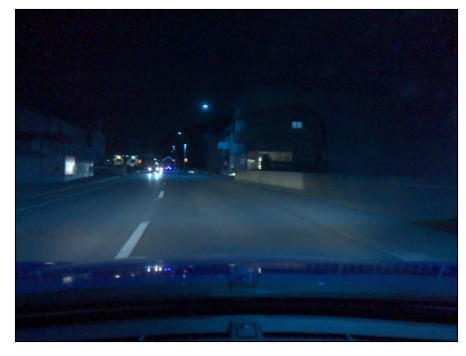

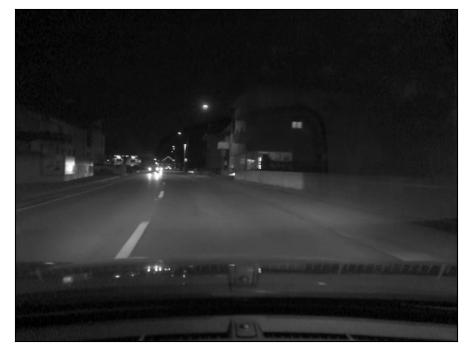

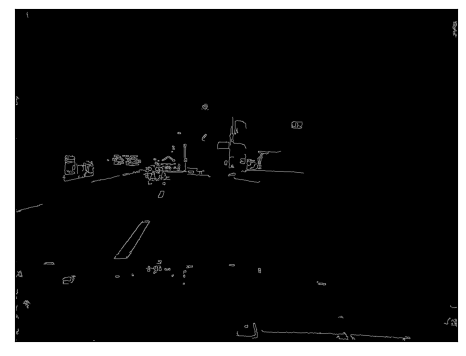

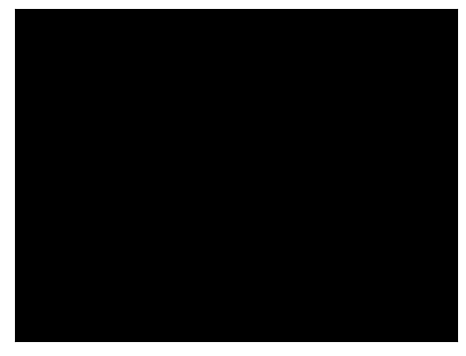

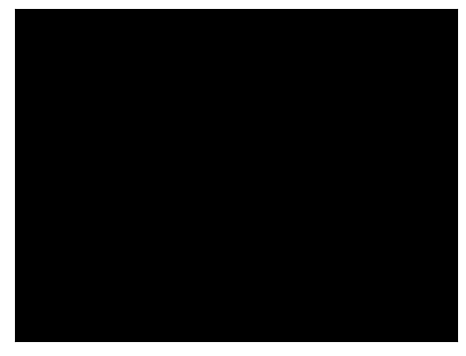

TypeError: 'NoneType' object is not iterable

In [38]:
seed(10)
for i in range(2):
    test_int = np.array([int(n) for n in test_vp])
    rand_idx = num = math.floor(random() * test_data.shape[0]) 
    rand_frame = test_data[rand_idx]
    show([rand_frame])
    intersection = debug_process_image(test_data[rand_idx])
    # cv2.circle(rand_frame, pt, 10, (0, 0, 255), 3)
    # cv2.circle(rand_frame, test_int, 10, (255, 0, 0), 3)
    # show([rand_frame])

In [3]:
# Without LaneMemory
seed(100)
count = 5
for i in range(count):
    rand_idx = num = math.floor(random() * test_data.shape[0]) 
    current_img = np.copy(test_data[rand_idx])
    hough_img, result, left_lane, right_lane, left_filter_img, right_filter_img, lane_img = debug_process_image(current_img)
    # print(left_lane, right_lane)
    show([hough_img, lane_img])
    # show([result])
        

NameError: name 'test_data' is not defined

(874, 1164, 3)
0.9611111111111112 -288.3333333333334
0.961111111111111 -1.8247728600663142e-14
-1.08 863.9999999999999
-1.0799999999999998 1187.9999999999995


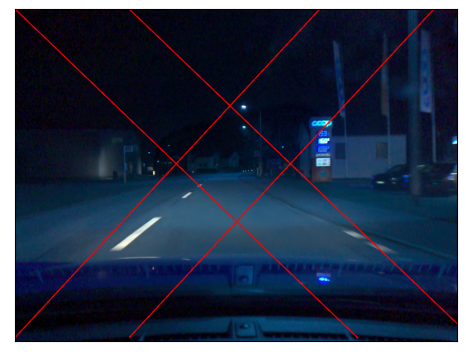

In [217]:
im_copy = np.copy(test_data[3000])
print(im_copy.shape)
right_lane = [1200, 865, 300, 0] # [x1, y1, x2, y2]
right_lane2 = [900, 865, 0, 0]
left_lane = [0, 864, 800, 0]
left_lane2 = [300, 864, 1100, 0]
test_lines = np.array([right_lane, right_lane2, left_lane, left_lane2])
for line in test_lines:
    x1, y1, x2, y2 = line.reshape(4)
    parameters = np.polyfit((x1, x2), (y1, y2), 1)
    slope = parameters[0]
    intercept = parameters[1]
    print(slope, intercept)

im_draw = draw_lines(im_copy, [test_lines])
show([im_draw])

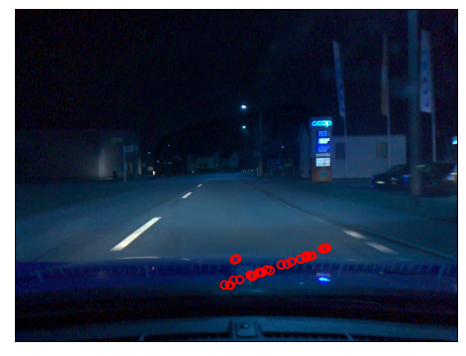

In [148]:
# NOT TRUTHY 500 697
# NOT TRUTHY 527 683
pts = [(565, 727),(617, 700),(775, 650),(813, 630),(780, 649),(818, 629),(648, 693),(661, 686),(626, 702),(643, 693),(621, 703),(639, 694),(564, 726),(590, 712),(550, 726),(573, 714),(670, 688),(699, 673),(714, 671),(726, 665),(750, 658),(767, 649),(764, 654),(808, 631),(749, 658),(765, 649),(576, 660),(582, 657)]

img_cop = np.copy(test_data[3000])
for pt in pts:
    cv2.circle(img_cop, pt, 10, (255, 0, 0), 4)
show([img_cop])